In [1]:
import os, pandas as pd, slr_pkg.clean_load_data as cld, slr_pkg.para as para
from itertools import combinations
from collections import Counter
from pathlib import Path


# Get current working directory
bp = Path(os.getcwd())

# Set base data directory.
dp  = bp / 'data'

# Set sample data directory.
edf_path = dp / 'geotracker_edf_results'
gama_path = dp / 'gama_results'

# Set location data directory.
geo_xy_path = dp / 'geotracker_xy'
gama_xy_path = dp / "gama_xy"

# Set results directory
results_path = bp / "results"

# Ask for county to gather data for.
# area = input('Enter county: ')
area = 'Ventura'
# areas = ['LosAngeles']

In [2]:
# List of contaminants.
chems = para.conts11

edf_files = edf_path.glob('**/*{}*.zip'.format(area))
gama_files = gama_path.glob('**/*{}*.zip'.format(area.lower()))

samples = cld.Sample_Data.full_dataset(edf_files, gama_files)



geo_xy_files = geo_xy_path.glob('**/*{}*.zip'.format(area))
gama_xy_files = gama_xy_path.glob('**/*.zip')

locations = cld.Location_Data.full_dataset(geo_xy_files, gama_xy_files)


# Join well location data to sample results.
samples = samples.merge(locations, left_on='WID', right_on='WID', how='inner')

print('Loading MCL table \n')

# Create path to mcl table.
mcl_path = dp / 'MCLs.xlsx'

# Open mcl table.
mcl = pd.read_excel(mcl_path,sheet_name='MCL', engine='openpyxl')

# join MCL values to sample results
print('Joining MCL values to samples \n')
samples = samples.merge(mcl, left_on='PARLABEL', right_on='chem_abrv', how='inner')

# Load conversion tables.
metric_conversion = pd.read_excel(bp / 'unit_conversion.xlsx', sheet_name='metric')

# join coversion factors to samples based on sample unit.
samples = samples.merge(metric_conversion, how='inner', left_on='UNITS', right_on='start_unit')
samples = samples.drop_duplicates(subset=['SID'], keep='first')


# Create mask for samples with MCL units in UG/L and converts sample result units to UG/L.
mask = samples['UNITS'] != samples['units']

# Multiply sample results by conversion factor.
samples.loc[mask, 'PARVAL'] = samples['PARVAL'] * samples['coef']
samples['UNITS'] = 'UG/L'

# Drop columns that are not needed.
samples.drop(columns=['REPDL','GID', 'SID','chem_abrv', 'units','comp_conc_type','start_unit', 'coef'], inplace=True)

# Create exceedence attribute, true if sample result exceeds reporting limit.
samples['exceedence'] = samples['PARVAL'] > samples['comp_conc_val']

# Create magnitude attribute. Sample result value divided by the comparison concentration value (MCL or Action level) minus 1.
samples['magnitude'] = (samples['PARVAL'] / samples['comp_conc_val']) - 1

# subset of specific samples meeting parameters.
spec_samples = samples.copy()

# Select spec_samples taken since 2010.
spec_samples = spec_samples.loc[spec_samples['LOGDATE'] >= '2012-01-01']

# Select samples with contaminants of interest.
spec_samples = spec_samples.loc[spec_samples['PARLABEL'].isin(chems)]

counter = Counter(spec_samples['PARLABEL'])
print(counter.most_common(1))

Loading Geotracker file: e:\work\projects\coast_slr\scripts\slr_ground_water_quality_\data\geotracker_edf_results\VenturaEDF.zip 
Creating WID column... 
Loading GAMA file: e:\work\projects\coast_slr\scripts\slr_ground_water_quality_\data\gama_results\gama_ddw_ventura_v2.zip 
Renaming GAMA columns... 
Loading GAMA file: e:\work\projects\coast_slr\scripts\slr_ground_water_quality_\data\gama_results\gama_dpr_ventura_v2.zip 
Renaming GAMA columns... 
Loading GAMA file: e:\work\projects\coast_slr\scripts\slr_ground_water_quality_\data\gama_results\gama_dwr_ventura_v2.zip 
Renaming GAMA columns... 
Loading GAMA file: e:\work\projects\coast_slr\scripts\slr_ground_water_quality_\data\gama_results\gama_gama_usgs_ventura_v2.zip 
Renaming GAMA columns... 
Loading GAMA file: e:\work\projects\coast_slr\scripts\slr_ground_water_quality_\data\gama_results\gama_usgs_nwis_ventura_v2.zip 
Renaming GAMA columns... 
Loading GAMA file: e:\work\projects\coast_slr\scripts\slr_ground_water_quality_\data\gama

In [3]:
def select_wells(row, c):
    wid = row['WID']
    counter = Counter(row['PARLABEL'])
    if len(counter) == len(c):
        if all(i >= 4 for i in counter.values()):
            return  wid

In [4]:
from collections import namedtuple

result = namedtuple('result', 'wells samples')

In [ ]:
c_dict = {}

for i in range(4,11):
    
    c_list = combinations(chems, i)
    c_list = list(c_list)

    for c in c_list:
        df = spec_samples[spec_samples['PARLABEL'].isin(c)].copy()
        grp = df.groupby('WID')['PARLABEL'].apply(list).reset_index()
        res = grp.apply(select_wells, axis=1, c=c)
        res_samples = spec_samples[spec_samples['WID'].isin(res)].copy()
        s = len(res_samples)
        w = len(res_samples['WID'].unique())
        c_dict[str(sorted(c))] = result(wells=w, samples=s)

In [10]:
cdf = pd.DataFrame.from_dict(c_dict, orient='index').reset_index().rename(columns={'index':'contaminants'})
cdf['c_num'] = cdf['contaminants'].apply(lambda x: len(x.replace('[','').replace(']','').replace("'",'').split(',')))

In [11]:
cdf.sort_values(by='wells', ascending=False, inplace=True)

In [12]:
cdf

,contaminants,wells,samples,c_num
326,"['BZ', 'BZME', 'EBZ', 'MTBE']",877,76007,4
325,"['BZ', 'BZME', 'EBZ', 'XYLENES']",687,54582,4
327,"['BZ', 'BZME', 'MTBE', 'XYLENES']",663,53819,4
328,"['BZ', 'EBZ', 'MTBE', 'XYLENES']",663,53819,4
329,"['BZME', 'EBZ', 'MTBE', 'XYLENES']",663,53819,4
...,...,...,...,...
418,"['EDB', 'PB', 'PCE', 'TCPR123', 'XYLENES']",48,6333,5
1347,"['BZ', 'CD', 'EBZ', 'EDB', 'TCE', 'TCPR123', '...",48,6333,7
1345,"['BZ', 'BZME', 'CD', 'EDB', 'TCE', 'TCPR123', ...",48,6333,7
1343,"['CD', 'EBZ', 'EDB', 'MTBE', 'PCE', 'TCPR123',...",48,6333,7


In [14]:
import matplotlib.pyplot as plt


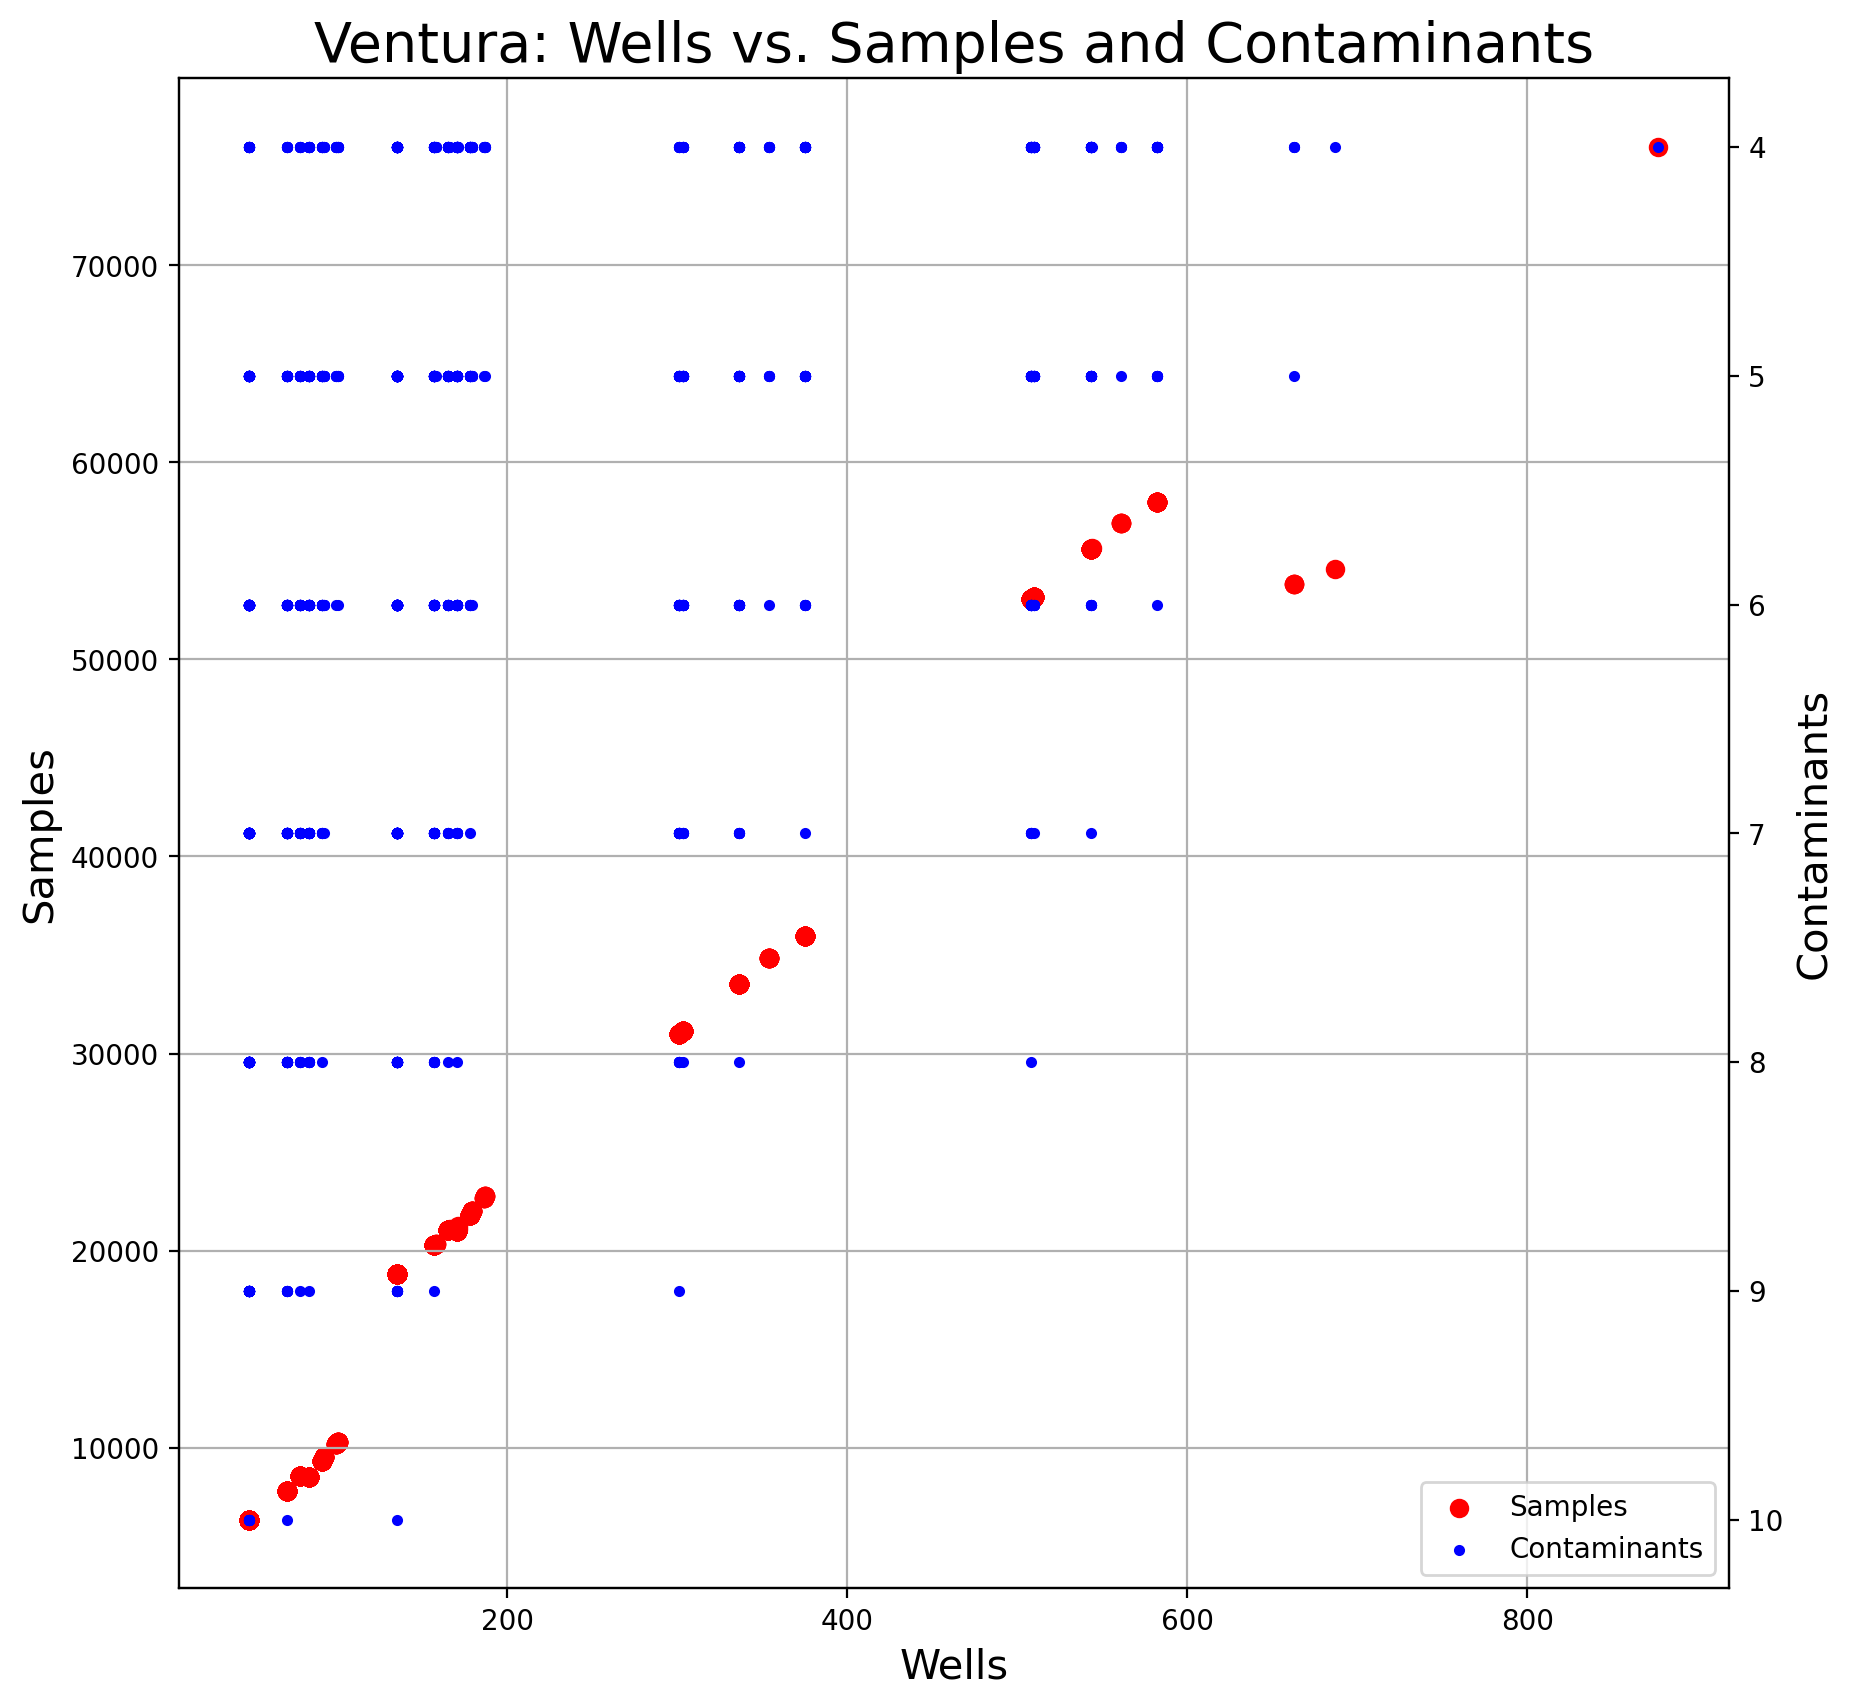

In [43]:
a = c_dict.values()
b = c_dict.keys()

x = cdf['wells']
y = cdf['samples']
z = cdf['c_num']

fig, ax1 = plt.subplots(figsize=(10,10), dpi=200)
p1 =ax1.scatter(x, y, color='red')
ax1.set(xlabel='Wells', ylabel='Samples', title='{}: Wells vs. Samples and Contaminants'.format(area))
ax1.set_xlabel('Wells', fontsize=15)
ax1.set_ylabel('Samples', fontsize=15)
ax1.set_title('{}: Wells vs. Samples and Contaminants'.format(area), fontsize=20)
ax1.grid()
ax2 = ax1.twinx()
p2 = ax2.scatter(x, z, marker='.', color='blue')
ax2.set_ylabel('Contaminants', fontsize=15)
ax2.invert_yaxis()
ax1.legend(handles=[p1, p2], labels=['Samples', 'Contaminants'], loc='lower right')

In [40]:
cdf.groupby('c_num').max()


,contaminants,wells,samples
c_num,,,
4,"['PCE', 'TCE', 'TCPR123', 'XYLENES']",877,76007
5,"['PB', 'PCE', 'TCE', 'TCPR123', 'XYLENES']",663,58008
6,"['MTBE', 'PB', 'PCE', 'TCE', 'TCPR123', 'XYLEN...",582,58008
7,"['EDB', 'MTBE', 'PB', 'PCE', 'TCE', 'TCPR123',...",543,55608
8,"['EBZ', 'EDB', 'MTBE', 'PB', 'PCE', 'TCE', 'TC...",508,53049
9,"['CD', 'EBZ', 'EDB', 'MTBE', 'PB', 'PCE', 'TCE...",301,30990
10,"['BZME', 'CD', 'EBZ', 'EDB', 'MTBE', 'PB', 'PC...",135,18811


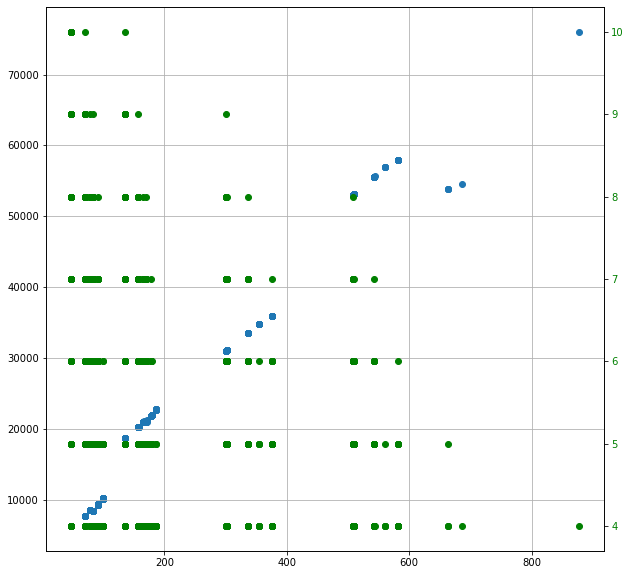

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

x = cdf['wells']
y = cdf['samples']
y2 = cdf['c_num']
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot()
line1 = plt.scatter(x,y)
ax1.grid(True)

ax2 = ax1.twinx()
line2 = ax2.scatter(x, y2, color='green')
ax2.tick_params(axis='y', labelcolor='green')

annots = []
for ax in [ax1, ax2]:
    annot = ax.annotate("", xy=(0,0), xytext=(-20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w", alpha=0.4),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    annots.append(annot)

annot_dic = dict(zip([ax1, ax2], annots))
line_dic = dict(zip([ax1, ax2], [line1, line2]))

def update_annot(line, annot, ind):
    x,y = line.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
    text = "x = {}\ny= {}".format(x[ind["ind"][0]], y[ind["ind"][0]])
    annot.set_text(text)

def hover(event):

    if event.inaxes in [ax1, ax2]:
        for ax in [ax1, ax2]:
            cont, ind = line_dic[ax].contains(event)
            annot = annot_dic[ax]
            if cont:
                update_annot(line_dic[ax], annot, ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if annot.get_visible():
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

In [ ]:
max_val = max(c_dict.values(), key=lambda sub: sub[0])

res = next(key for key, val in c_dict.items() if val == max_val)

# printing result
print("The maximum key : " + str(res))

In [ ]:
cdf.plot(kind='scatter',x='wells', y = 'samples' ,figsize=(20,20))

Text(0.5, 0, 'Wells')

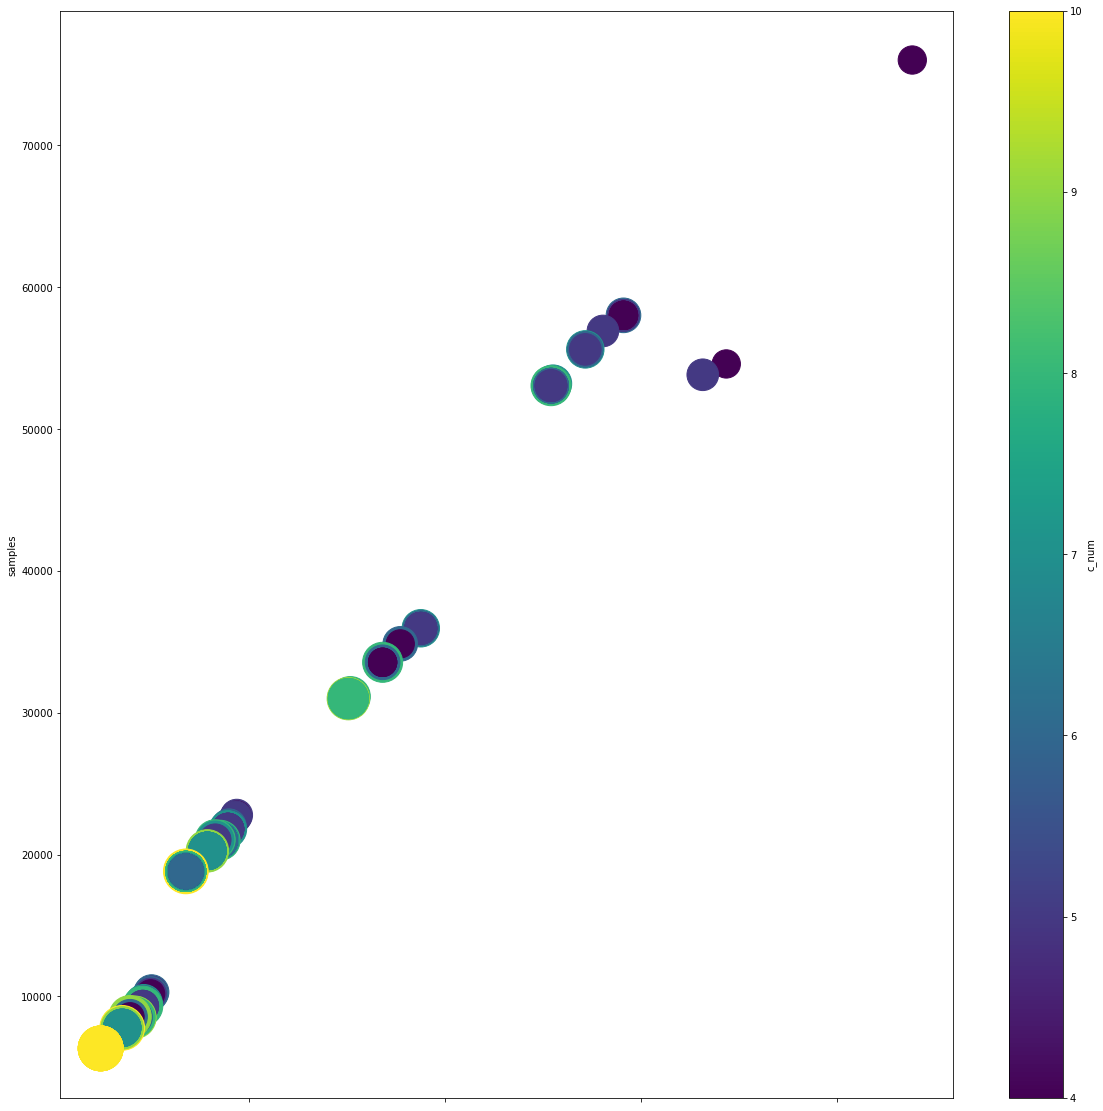

In [16]:
ax = cdf.plot.scatter(x='wells', y = 'samples' , c='c_num', cmap='viridis', s=cdf['c_num']*200, figsize=(20,20))

ax.set_xlabel('Wells')

In [ ]:
cdf.plot(x='c_num', y='wells', kind='bar', color='red', label='Wells')

In [ ]:
cdf.plot(kind='scatter', x='wells', y='samples', color='red', label='Samples')